In [22]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def generate_filenames_from_dir(data_dir,ext='jpg', infer_labels_from_parentdir=False):
    '''
    Utility function to generate filenames of given extension from a parent directory
    Arguments:
    ----------
    data_dir - parent directory containing files
    ext - file extension to filter
    infer_labels_from_parentdir = generate labels from name of parent directory
    For e.g if data_dir is data_dir-->cat--> *.jpg
                                   |->dog--> *.jpg
        then a a integer label will be generated for each category [cat -0, dog-1]
    
    Return:
    ------
    file_names - list of file_names
    labels - list of labels if infer_labels_from_parentdir is True else None
    label_dict - a dictionary from caetgories to integer ids for labels i.e {'cat':0,'dog':1}
    '''
    file_names = []
    labels = []
    label_dict = {}
    category_count = 0
    for path,dirs,files in os.walk(data_dir):
        if len(dirs) == 0:
            if infer_labels_from_parentdir is True:
                parent_dir = os.path.dirname(os.path.join(path,files[0])).split(os.sep)[-1]
                label_dict[parent_dir] = category_count
                category_count +=1
            else:
                labels = None
            for file in files:
                if ext is not None and ext in file:
                    file_names.append(os.path.join(path, file))
                    if infer_labels_from_parentdir is True:
                        labels.append(label_dict[parent_dir])

    return file_names, labels, label_dict

In [44]:
resize_height = 224
resize_width = 224

def _parse_function(filename):
    '''
    function to load, decode and resize images as part of dataset input pipeline.
    Can apply any other image preprocessing transformations
    
    '''
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.cast(image_decoded,tf.float32)
    image_resized =  tf.image.resize_images(image_decoded,(resize_height, resize_width))
    return image_resized

def _parse_function_with_labels(filename, label):
    '''
    function to load, decode and resize images as part of dataset input pipeline.
    Can apply any other image preprocessing transformations. Additionally returns
    labels associated with image (pass-thru)
    
    '''
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded = tf.cast(image_decoded,tf.float32)
    image_resized =  tf.image.resize_images(image_decoded,(resize_height, resize_width))
    return image_resized, label

def _add_image_file_generator(image_file_names, labels=None, batch_size=32):
    '''
    generates a image processing block to the current graph. It uses TF 1.2 new Dataset API
    to process a list of files and load the image, preprocess and return it along with
    optionally associated labels
    
    Arguments:
    ----------
    image_file_names - 1-D tensor of image names
    labels - associated labels with each image, [optional]
    batch_size - number of images,[labels] returned per batch
    
    Returns: A iterator that returns a batch of images,[labels] defined by batch_size
    '''
    with tf.name_scope('image_gen') as scope:
        if labels is not None:
            dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(image_file_names), tf.constant(labels)))
            dataset = dataset.shuffle(buffer_size=len(image_file_names))
            dataset = dataset.map(_parse_function_with_labels)
        else:
            dataset = tf.contrib.data.Dataset.from_tensor_slices((tf.constant(image_file_names)))
            dataset = dataset.shuffle(buffer_size=len(image_file_names))
            dataset = dataset.map(_parse_function)
        dataset = dataset.batch(batch_size)
        iterator = dataset.make_initializable_iterator()
        return iterator

In [45]:
data_dir = '../../data/dogsvscats/train'
file_names, labels,labels_dict = generate_filenames_from_dir(data_dir, infer_labels_from_parentdir=True)


In [46]:
print(file_names[:10])
print(labels_dict)

['../../data/dogsvscats/train\\cats\\cat.1000.jpg', '../../data/dogsvscats/train\\cats\\cat.10000.jpg', '../../data/dogsvscats/train\\cats\\cat.10001.jpg', '../../data/dogsvscats/train\\cats\\cat.10002.jpg', '../../data/dogsvscats/train\\cats\\cat.10003.jpg', '../../data/dogsvscats/train\\cats\\cat.10004.jpg', '../../data/dogsvscats/train\\cats\\cat.10005.jpg', '../../data/dogsvscats/train\\cats\\cat.10006.jpg', '../../data/dogsvscats/train\\cats\\cat.10007.jpg', '../../data/dogsvscats/train\\cats\\cat.10008.jpg']
{'cats': 0, 'dogs': 1}


In [47]:
tf.reset_default_graph()
# get iterator to load, preprocess images
iterator = _add_image_file_generator(file_names, labels)
with tf.Session() as sess:
    sess.run(iterator.initializer)
    # get first batch of images
    result = sess.run(iterator.get_next())
sess.close()

In [48]:
print(result[0].shape)

(32, 224, 224, 3)


In [49]:
print(result[1].shape)

(32,)


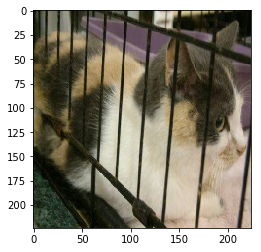

In [50]:
plt.imshow(result[0][0]/255.0)